<table align="left">
  <td>
    <a href="https://is.gd/hoIMVZ" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## Experimentos CNN - MNIST Fashion Dataset

En este notebook utilizaremos el dataset de MNIST Fashion para entrenar una red neuronal convolucional (CNN) para clasificar imágenes de ropa. 

El dataset MNIST Fashion contiene 70,000 imágenes en escala de grises de 28x28 píxeles, cada una de las cuales pertenece a una de las 10 clases de ropa. El dataset está dividido en 60,000 imágenes de entrenamiento y 10,000 imágenes de prueba. Cada imagen está etiquetada con una sola etiqueta de clase, que es un entero de 0 a 9.

Las clases son:
- 0	T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

El dataset se puede cargar directamente desde Keras. Para ello, utilizaremos la función `load_data()` de la librería `keras.datasets.fashion_mnist`.

Este notobook se utilizará como base para realizar los siguientes experimentos:

- Experimento 1: Estructura VGG1
- Experimento 2: Estructura VGG2
- Experimento 3: Estructura VGG3
- Experimento 4: Estructura VGG3 + Dropout (0.2)
- Experimento 5: Estructura VGG3 + Dropout (0.5)
- Experimento 6: Estructura VGG3 + Batch Normalization
- Experimento 7: Estructura VGG3 + Batch Normalization + Dropout (0.2)
- Experimento 8: Estructura VGG3 + Batch Normalization + Data Augmentation
- Experimento 9: Estructura VGG3 + Batch Normalization + Dropout (0.2) + Data Augmentation
- Experimento 10: Estructura VGG3 + Batch Normalization + Dropout (0.5) + Data Augmentation

## **Paso 1.** Importar las librerías

In [1]:

import tensorflow as tf
from tensorflow import keras
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model 
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K 
K.set_image_data_format('channels_last')



# to make this notebook's output stable across runs
np.random.seed(42)

import Modelos_Exp_CNN as cnnexp

## **Paso 2.** Cargar el dataset. 

Se utilizará el Fashion MNIST. El dataset contiene 70,000 imagenes en escala de grises de 28x28 pixeles cada una, organizadas en 10 clases.

* Se utiliza keras para cargar el dataset. 
* Se realiza la separación del batch para entrenamiento y testeo, dejando 60,000 imagenes en escala de griste de de 28x28 pixeles para el set de entrenamiento. 

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# reshape dataset to have a single channel
X_train_full = X_train_full.reshape((X_train_full.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [4]:
X_train_full.shape

(60000, 28, 28, 1)

### Tratamiento de los datos
Se Divide el conjunto de entrenamiento completo en un subconjunto de validación y un subconjunto de entrenamiento (más pequeño). También se escala la intensidad de los píxeles en el rango de 0-1 y se convierten en flotantes, dividiéndolos por 255.

![Split Data](https://806230.smushcdn.com/1739487/wp-content/uploads/2021/04/train-and-test-1-min-1.png )

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split((X_train_full/250.0),y_train_full, test_size=0.1)
X_test = X_test / 255.0

### Las etiquetas son los IDs de las clases, representados de 0 a 9. 

In [6]:
# nombres de las clases
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# La primera imagen en el set de entrenamiento es una Coat. 
class_names[y_train[0]]

'Sandal'

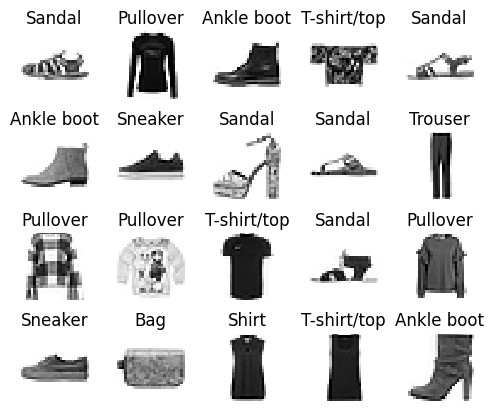

In [7]:
#Imagenes del dataset
n_rows = 4
n_cols = 5
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

### Data Augmentation

Dado que el conjunto de datos se compone de pequeñas fotos de objetos, no queremos utilizar aumentos que distorsionen demasiado las imágenes, para poder conservar y utilizar las características útiles de las mismas.

Los tipos de aumentos aleatorios que se utilizarán son:: 
 - giro horizontal, 
 - desplazamientos del 10% en la altura y la anchura de la imagen.

In [8]:
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator - DA_train = data augmentation x_train, y_train
DA_train = datagen.flow(X_train, y_train, batch_size=64)

## **Paso 3.** Creación del modelo.

En la siguiente imagen se muestran las tres estructuras bases de la red neuronal convolucional que se utilizaran para resolver el problema de clasificación de imágenes de ropa.

<a href="https://ibb.co/fqQqYcX"><img src="https://i.ibb.co/GnFnvhd/imagen-2022-11-05-223615366.png" alt="experimentos" border="0" width="500" height="250"></a>

### Lista de Experimentos a Realizar
- Experimento 1: Estructura VGG1
- Experimento 2: Estructura VGG2
- Experimento 3: Estructura VGG3
- Experimento 4: Estructura VGG3 + Dropout (0.2)
- Experimento 5: Estructura VGG3 + Dropout (0.5)
- Experimento 6: Estructura VGG3 + Batch Normalization
- Experimento 7: Estructura VGG3 + Batch Normalization + Dropout (0.2)
- Experimento 8: Estructura VGG3 + Batch Normalization + Data Augmentation
- Experimento 9: Estructura VGG3 + Batch Normalization + Dropout (0.2) + Data Augmentation
- Experimento 10: Estructura VGG3 + Batch Normalization + Dropout (0.5) + Data Augmentation




In [9]:
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
## Modelo Secuencial Keras
keras.backend.clear_session()
model = Sequential()

In [11]:
## Función creada para seleccionar el modelo
## parametro 1: modelo keras
## parametro 2: "mnist" o "cifar10"
## Num Experimento: 1 - 10
model, exp_name = cnnexp.select_exp(model,"mnist", 9)

Experimento:  9


In [12]:
input_shape = X_train.shape  
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (54000, 28, 28, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (54000, 28, 28, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (54000, 28, 28, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (54000, 28, 28, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (54000, 14, 14, 32)       0         
_________________________________________________________________
dropout (Dropout)            (54000, 14, 14, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (54000, 14, 14, 64)       1

## **Paso 4.** Compilando el modelo y entrenando el modelo. 


*   **loss**: "sparse_categorical_crossentropy", se utiliza está función dado que se cuenta con un número de etiquetas escasas (sparse) - no binarias.
*   **optimizer** = Adam. 
*   **metrics**: Exactitud (accuracy)


In [13]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

### 4.1 Callbacks - Guardar el mejor modelo durante el entrenamiento

- Al utilizar datos de validación durante el entrenamiento es posible salvar el ultimo mejor modelo.
- Actualizar la variable exp_name con el nombre del experimento a realizar.

In [14]:
if exp_name == "Exp_8" or exp_name == "Exp_9" or exp_name == "Exp_10":
    # Tensorflow savemodel format
    best_model_name = "Trained_Models/fashion_model_" + exp_name
else:
    best_model_name = "Trained_Models/fashion_model_" + exp_name + ".h5"
print(best_model_name)

Trained_Models/fashion_model_Exp_9


In [15]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(best_model_name, save_best_only=True)

In [16]:
if exp_name == "Exp_8" or exp_name == "Exp_9" or exp_name == "Exp_10":
    # Fit the model on the batches generated by datagen.flow().
    print("Entrenando modelo " + exp_name + " Con Data Augmentation") 
    steps = int(X_train.shape[0] / 64)
    history = model.fit(DA_train, steps_per_epoch=steps, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb], verbose=0)
else:
    print("Entrenando modelo " + exp_name + " sin data augmentation") 
    history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb], verbose=0)

Entrenando modelo Exp_9 Con Data Augmentation
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets
INFO:tensorflow:Assets written to: Trained_Models\fashion_model_Exp_9\assets


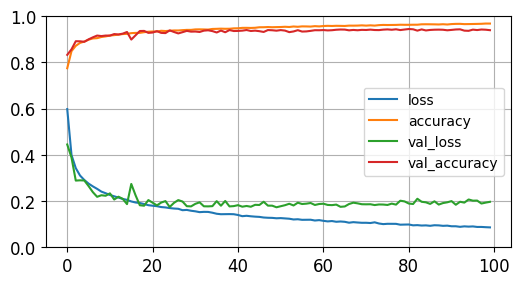

In [17]:
# se utiliza pandas para visualizar la información almacenada en el diccionario de historia de entrenamiento y graficarla. 
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(6, 3))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## **Paso 5.** Evaluación del modelo. 
Se evalua el modelo con el conjunto de datos de prueba.

- X_train: Conjunto de datos de entrenamiento.
- y_train: Etiquetas de los datos de entrenamiento.
- X_valid: Conjunto de datos de validación.
- y_valid: Etiquetas de los datos de validación.
- X_test: Conjunto de datos de prueba.
- y_test: Etiquetas de los datos de prueba.


In [18]:
model = load_model(best_model_name)

In [19]:
scores_train = model.evaluate(X_train, y_train)
scores_valid = model.evaluate(X_valid, y_valid)
scores_test = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1757 - accuracy: 0.9413


In [20]:
print('train loss:', round(scores_train[0]*100,2), '%')
print('valid loss:', round(scores_valid[0]*100,2), '%')
print('test loss:', round(scores_test[0]*100,2), '%')
print("\n")
print('train accuracy:', round(scores_train[1]*100,2), '%')
print('valid accuracy:', round(scores_valid[1]*100,2), '%')
print('test accuracy:', round(scores_test[1]*100,2), '%')

train loss: 8.78 %
valid loss: 17.32 %
test loss: 17.57 %


train accuracy: 96.86 %
valid accuracy: 93.77 %
test accuracy: 94.13 %


## **Paso 6.** Usando el modelo para hacer predicciones. 

Se toman 5 instancias del set de prueba para hacer la predicción. y se imprime la matriz de probabilidad para cada una de las instancias. 

In [22]:
X_new = X_test[10:15]
y_proba = model.predict(X_new)

In [23]:
classes_x = np.argmax(y_proba,axis=1)

In [24]:
# Valores predichos
np.array(class_names)[classes_x]

array(['Coat', 'Sandal', 'Sneaker', 'Dress', 'Coat'], dtype='<U11')

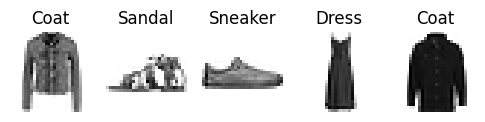

In [27]:
y_new = y_test[10:15]
plt.figure(figsize=(6, 2))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_new[index]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()